In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from datetime import timedelta
import requests


In [ ]:
df = pd.read_csv("Dataset_borewells.csv")

# Create proper date
df['date'] = pd.to_datetime(df[['Year','Month','Day']])

# Sort chronologically per borewell
df = df.sort_values(['Borewell_ID','date']).reset_index(drop=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lag features
df['GW_lag_1'] = df.groupby('Borewell_ID')['GW_Level_m'].shift(1)
df['GW_lag_7'] = df.groupby('Borewell_ID')['GW_Level_m'].shift(7)

# Rolling rainfall (7 days)
df['Rain_7day'] = (
    df.groupby('Borewell_ID')['Rainfall_mm']
      .rolling(7)
      .sum()
      .reset_index(level=0, drop=True)
)

# Groundwater trend slope (early warning)
df['GW_trend_7'] = (
    df.groupby('Borewell_ID')['GW_Level_m']
      .rolling(7)
      .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
      .reset_index(level=0, drop=True)
)

# Recharge delay indicator
df['Recharge_Delay'] = (df['Rain_7day'] > 20).astype(int)

# Drop NA rows
df = df.dropna().reset_index(drop=True)


In [ ]:
features = [
    'latitude', 'longitude',
    'Rainfall_mm', 'Rain_7day',
    'temperature',
    'GW_lag_1', 'GW_lag_7',
    'GW_trend_7',
    'Recharge_Delay'
]

X = df[features]
y = df['GW_Level_m']

# Time-aware split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))


MAE: 0.05146749019799659
R²: 0.9269948265791357


In [ ]:
def get_weather_forecast(lat, lon):
    API_KEY = "902943b2c73368b249514228bdad43a6"

    url = (
        f"https://api.openweathermap.org/data/2.5/forecast"
        f"?lat={lat}&lon={lon}&appid={API_KEY}&units=metric"
    )

    data = requests.get(url).json()

    daily = {}
    for item in data['list']:
        date = item['dt_txt'][:10]
        if date not in daily:
            daily[date] = {
                'temperature': item['main']['temp'],
                'Rainfall_mm': item.get('rain', {}).get('3h', 0)
            }

    return pd.DataFrame(daily).T.reset_index(drop=True).head(30)


In [ ]:
def get_starting_row(df, borewell_id, selected_date):

    hist = df[
        (df['Borewell_ID'] == borewell_id) &
        (df['date'] <= selected_date)
    ].sort_values('date')

    if len(hist) < 8:
        raise ValueError("Not enough historical data before selected date")

    return hist.iloc[-1]


In [ ]:
def get_weather_for_date(df, last_row, selected_date):

    today = pd.to_datetime("today").normalize()

    # Past date → historical weather
    if selected_date < today:
        weather = df[
            (df['latitude'] == last_row['latitude']) &
            (df['longitude'] == last_row['longitude']) &
            (df['date'] > selected_date)
        ][['temperature','Rainfall_mm']].head(30)

        return weather.reset_index(drop=True)

    # Present / future → API
    else:
        return get_weather_forecast(
            last_row['latitude'],
            last_row['longitude']
        )


In [ ]:
def predict_30_days(model, df, borewell_id, selected_date):

    last = get_starting_row(df, borewell_id, selected_date)
    weather = get_weather_for_date(df, last, selected_date)

    future = []
    gw_prev = last['GW_Level_m']
    gw_7 = last['GW_lag_7']

    rain_buffer = [last['Rainfall_mm']] * 7
    avg_rain = weather['Rainfall_mm'].mean()
    avg_temp = weather['temperature'].mean()

    for i in range(30):

        if i < len(weather):
            rain = weather.iloc[i]['Rainfall_mm']
            temp = weather.iloc[i]['temperature']
        else:
            rain = avg_rain
            temp = avg_temp

        rain_buffer.pop(0)
        rain_buffer.append(rain)

        row = pd.DataFrame([{
            'latitude': last['latitude'],
            'longitude': last['longitude'],
            'Rainfall_mm': rain,
            'Rain_7day': sum(rain_buffer),
            'temperature': temp,
            'GW_lag_1': gw_prev,
            'GW_lag_7': gw_7,
            'GW_trend_7': (gw_prev - gw_7) / 7,
            'Recharge_Delay': int(sum(rain_buffer) > 20)
        }])

        gw_pred = model.predict(row)[0]

        gw_7 = gw_prev
        gw_prev = gw_pred
        future.append(gw_pred)

    return future


In [ ]:
def risk_and_alert(future_gw):

    drop = future_gw[-1] - future_gw[0]

    if drop > 0.5:
        risk = "HIGH RISK"
    elif drop > 0.2:
        risk = "MODERATE RISK"
    else:
        risk = "SAFE"

    recharge = (
        "RECHARGE ALERT"
        if min(future_gw) < future_gw[0]
        else "NO ALERT"
    )

    return risk, recharge


In [ ]:
selected_borewell = "borewell_2"
selected_date = pd.to_datetime("2022-10-15")

future = predict_30_days(
    model, df, selected_borewell, selected_date
)

risk, alert = risk_and_alert(future)

print("Borewell:", selected_borewell)
print("Start date:", selected_date.date())
print("Day-30 GW Level:", round(future[-1], 2))
print("Risk:", risk)
print("Recharge:", alert)


Borewell: borewell_2
Start date: 2022-10-15
Day-30 GW Level: 16.59
Risk: SAFE
Recharge: RECHARGE ALERT


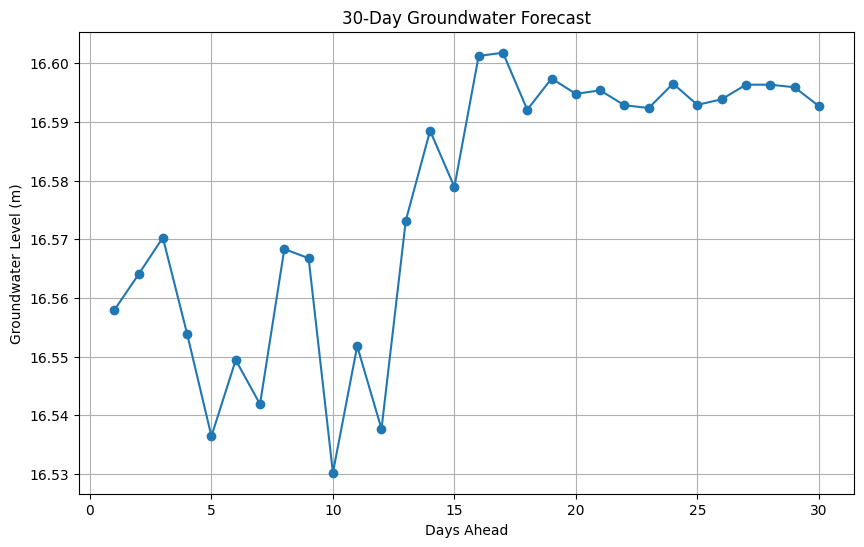

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,31), future, marker='o')
plt.xlabel("Days Ahead")
plt.ylabel("Groundwater Level (m)")
plt.title("30-Day Groundwater Forecast")
plt.grid()
plt.show()


In [ ]:
import joblib

# Save model
joblib.dump(model, "groundwater_prediction_model.pkl")

print("Model saved as groundwater_prediction_model.pkl")


Model saved as groundwater_prediction_model.pkl
